## Gluon Object Detection

SSD这种检测方法咋感觉有点像FPN，特征金字塔，在较底层的特征有着较高的分辨率，在较高的特征有着较低的分辨率，它在高分辨率和低分便率都进行class predict和box predict。让我们首先了解一下anchor box是个什么东西。

我们知道，proposal的提取是每个像素点都会提取一遍anchor，也就是prior的区域，那么问题来了：
- 所谓每一个像素点，是所有的像素点吗？如果不是第一个提取proposal的像素点是哪个？
- 如果size是原尺寸的一半，也就是scale 0.5,那么它的不同ratio得到的具体size怎么计算？

上面两个问题中，首先是proposal开始的第一个像素点开始的位置，这里其实应该是从最大的scale的中心位置开始，比如，下面的anchor中，最大的scale是1,也就是原图，那么它的中心位置就是所有像素点的开始。那么问题又来了，这是第一个像素点，那最后一个像素点呢？为什么要从scale为1的中心位置开始作为一个像素点进行proposal的提取呢？

In [1]:
import mxnet as mx
from mxnet import nd
from mxnet.contrib.ndarray import MultiBoxPrior
from mxnet.gluon import nn
from mxnet import gluon

n = 40
w = 40
h = 40
x = nd.random_uniform(shape=(1, 3, w, h))
y = MultiBoxPrior(x, sizes=[0.5, 0.25, 0.1], ratios=[1, 2, 0.5])
# 我们的到了8000个proposal, 如果是每一个像素点都提取9个anchor，那么应该是14400个anchor，但是实际上只有8000个
# 这是为毛呢 
print(y.shape)

# 按照每行每列的anchor来shape一下, 这5怎么来的呢，我草
boxes = y.reshape((w, h, -1, 4))
print(boxes.shape)

(1, 8000, 4)
(40, 40, 5, 4)


按道理，这里如果说每一个像素都提取9个anchor，那么应该是会产生14400个anchor，但是这个MultiBoxPrior却只产生了8000个anchor。为什么会这样呢？在教程里面有这么一句话，来仔细理解一下：

*The first i boxes are generated from sizes[i], ratios[0] if i≤n
 otherwise sizes[0], ratios[i-n].*
 
 其中n指的是n中sizes，这句话的意思是，我们有n个sizes，m个ratios，那么产生的boxes**并不是我们想象的n\*m**，而是**n+m-1**:
 
 ```
 i = 1, sizes[0], ratios[0]
 i = 2, sizes[1], ratios[0]
 i = 3, sizes[2], ratios[0]
 i = 4, sizes[0], ratios[1]
 i = 5, sizes[0], ratios[2]
 ```
 为什么是1-5？因为3+3-1=5, 为什么ratios[0]的时候对应这个3个sizes，而ratios[1]和ratios[2]都只对应了sizes[0]呢？？
我们看看具体的数值：
 ```
 i = 1, sizes[0]:0.5, ratios[0]:1
 i = 2, sizes[1]:0.25, ratios[0]:1
 i = 3, sizes[2]:0.1, ratios[0]:1
 i = 4, sizes[0]:0.5, ratios[1]:2
 i = 5, sizes[0]:0.5, ratios[2]:0.5
 ```
 我们算是看明白了：
 - 这样做基于样本中大部分物体是正方形的，这样从0.5-0.1，确保都有比例为1的anchor；
 - 在均匀尺度也就是0.5这个size上，不大不小，覆盖了2, 0.5，1等极端比例，这就意味着，在均匀物体上，尽量把多个尺度检测出来。
 - 再仔细看看，为什么size在四分之一和十分之的时候只有1的ratios呢？这是因为这个时候基本上都是小物体了，有两个原因这么做，首先第一个是样本中小物体都是方形的，第二个是小物体没有必要去追求非主流尺度，因为十分之一非常非常小了，非主流尺度反而会不准确。
 
这样一来，生成8000个anchor也就不足为奇了。但是问题又来了。按照这个理论，我改一下sizes和ratios的顺序，生成的框不就是不同了么？那这么做还有什么意义呢？这个MultiBoxPrior里面处理的逻辑究竟是怎么样的呢？

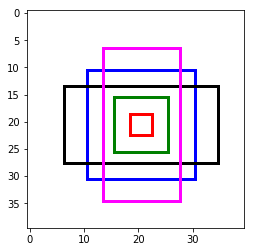

In [2]:
import matplotlib.pyplot as plt
def box_to_rect(box, color, linewidth=3):
    """convert an anchor box to a matplotlib rectangle"""
    box = box.asnumpy()
    return plt.Rectangle(
        (box[0], box[1]), (box[2]-box[0]), (box[3]-box[1]),
        fill=False, edgecolor=color, linewidth=linewidth)
colors = ['blue', 'green', 'red', 'black', 'magenta']
plt.imshow(nd.ones((n, n, 3)).asnumpy())
anchors = boxes[20, 20, :, :]
for i in range(anchors.shape[0]):
    plt.gca().add_patch(box_to_rect(anchors[i,:]*n, colors[i]))
plt.show()

从图上来看，更加清晰了，看到没，在最里面的十分之一的size里面，并没有1：2或者是2：1这样的ratios，所以跟上面的是一致的。但是我想不通，如果是增加1：2和2：1在小的size上，那么会有什么不同呢？为什么不加呢？(如果你想明白了这个问题，可以给我submit一个PR来让大家理解一下。)

带着一些疑问和不解，我们继续来进入最复杂的三个部分：
- 预测类别
- 预测boxes
- 降采样，以及SSD中独有的，在每层降采样中都预测类别和boxes，并把多层的结果融合到一起

In [3]:
# 这个类别预测网络，简直他妈的精简到想哭，简单到只有一层卷积，这个卷积的通道数
# 是anchor的个数乘以类别，anchor指的是每个像素点的个数，那么相当于是，
# 每个anchor都会生成一个类别
def class_predictor(num_anchors, num_classes):
    return nn.Conv2D(num_anchors * (num_classes + 1), 3, padding=1)

cls_pred = class_predictor(5, 10)
cls_pred.initialize()
x = nd.zeros([2, 3, 20, 20])
print('class prediction: ', cls_pred(x).shape)

class prediction:  (2, 55, 20, 20)


这个类别预测最终输出了55，因为anchor是5，类别是10，加一是因为加上了背景这个类别，那么很显然，这个class predictor就可以对输入的特征，得到的每一个anchor都预测一个类别了。这里的2是什么？batch_size吗？**还有那里的卷积的stride为什么是3?**

In [4]:
def box_predictor(num_anchors):
    return nn.Conv2D(num_anchors * 4, 3, padding=1)

box_pred = box_predictor(10)
box_pred.initialize()
x = nd.zeros([2, 3, 20, 20])
print('box prediction: ', box_pred(x).shape)

box prediction:  (2, 40, 20, 20)


In [5]:
def down_sample(num_filters):
    out = nn.HybridSequential()
    for _ in range(2):
        out.add(nn.Conv2D(num_filters, 3, strides=1, padding=1))
        out.add(nn.BatchNorm(in_channels=num_filters))
        out.add(nn.Activation('relu'))
    out.add(nn.MaxPool2D(2))
    return out
blk = down_sample(10)
blk.initialize()
x = nd.zeros([2, 3, 20, 20])
print('before: ', x.shape, 'after: ', blk(x).shape)

before:  (2, 3, 20, 20) after:  (2, 10, 10, 10)


In [6]:
feat1 = nd.zeros((2, 8, 20, 20))
print('Feature map 1', feat1.shape)
cls_pred1 = class_predictor(5, 10)
cls_pred1.initialize()
y1 = cls_pred1(feat1)
print('Class prediction for feature map 1', y1.shape)
# down-sample
ds = down_sample(16)
ds.initialize()
feat2 = ds(feat1)
print('Feature map 2', feat2.shape)
cls_pred2 = class_predictor(3, 10)
cls_pred2.initialize()
y2 = cls_pred2(feat2)
print('Class prediction for feature map 2', y2.shape)


Feature map 1 (2, 8, 20, 20)
Class prediction for feature map 1 (2, 55, 20, 20)
Feature map 2 (2, 16, 10, 10)
Class prediction for feature map 2 (2, 33, 10, 10)


In [7]:
def flatten_prediction(pred):
    return nd.flatten(nd.transpose(pred, axes=(0, 2, 3, 1)))

def concat_predictions(preds):
    return nd.concat(*preds, dim=1)

flat_y1 = flatten_prediction(y1)
print('Flatten class prediction 1', flat_y1.shape)
flat_y2 = flatten_prediction(y2)
print('Flatten class prediction 2', flat_y2.shape)
print('Concat class predictions', concat_predictions([flat_y1, flat_y2]).shape)

Flatten class prediction 1 (2, 22000)
Flatten class prediction 2 (2, 3300)
Concat class predictions (2, 25300)


这里，将两层featuremap出来的class predictor的预测concat到一起，但是是falatten之后，在concat。这样的话，两层的特征出来之后，我每层特征都做class predict，得到的结果我concat到一起。

In [8]:
def body():
    out = nn.HybridSequential()
    for f in [16, 32, 64]:
        out.add(down_sample(f))
    return out

b_net = body()
b_net.initialize()
x = nd.zeros([2, 3, 256, 256])
print('body network: ', b_net(x).shape)

body network:  (2, 64, 32, 32)


In [9]:

def toy_ssd_model(num_anchors, num_classes):
    """return SSD modules"""
    downsamples = nn.Sequential()
    class_preds = nn.Sequential()
    box_preds = nn.Sequential()

    downsamples.add(down_sample(128))
    downsamples.add(down_sample(128))
    downsamples.add(down_sample(128))

    for scale in range(5):
        class_preds.add(class_predictor(num_anchors, num_classes))
        box_preds.add(box_predictor(num_anchors))
    return body(), downsamples, class_preds, box_preds

print(toy_ssd_model(5, 2))

(HybridSequential(
  (0): HybridSequential(
    (0): Conv2D(16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm(axis=1, eps=1e-05, momentum=0.9, fix_gamma=False, in_channels=16)
    (2): Activation(relu)
    (3): Conv2D(16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm(axis=1, eps=1e-05, momentum=0.9, fix_gamma=False, in_channels=16)
    (5): Activation(relu)
    (6): MaxPool2D(size=(2, 2), stride=(2, 2), padding=(0, 0), ceil_mode=False)
  )
  (1): HybridSequential(
    (0): Conv2D(32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm(axis=1, eps=1e-05, momentum=0.9, fix_gamma=False, in_channels=32)
    (2): Activation(relu)
    (3): Conv2D(32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm(axis=1, eps=1e-05, momentum=0.9, fix_gamma=False, in_channels=32)
    (5): Activation(relu)
    (6): MaxPool2D(size=(2, 2), stride=(2, 2), padding=(0, 0), ceil_mode=False)
  )
  (2): HybridSequential(
    (0): C

In [10]:
def toy_ssd_forward(x, body, downsamples, class_preds, box_preds, sizes, ratios):
    # extract feature with the body network
    x = body(x)

    # for each scale, add anchors, box and class predictions,
    # then compute the input to next scale
    default_anchors = []
    predicted_boxes = []
    predicted_classes = []

    for i in range(5):
        default_anchors.append(MultiBoxPrior(x, sizes=sizes[i], ratios=ratios[i]))
        predicted_boxes.append(flatten_prediction(box_preds[i](x)))
        predicted_classes.append(flatten_prediction(class_preds[i](x)))
        if i < 3:
            x = downsamples[i](x)
        elif i == 3:
            # simply use the pooling layer
            x = nd.Pooling(x, global_pool=True, pool_type='max', kernel=(4, 4))

    return default_anchors, predicted_classes, predicted_boxes

In [11]:
class ToySSD(gluon.Block):
    def __init__(self, num_classes, **kwargs):
        super(ToySSD, self).__init__(**kwargs)
        # anchor box sizes for 4 feature scales
        self.anchor_sizes = [[.2, .272], [.37, .447], [.54, .619], [.71, .79], [.88, .961]]
        # anchor box ratios for 4 feature scales
        self.anchor_ratios = [[1, 2, .5]] * 5
        self.num_classes = num_classes

        with self.name_scope():
            self.body, self.downsamples, self.class_preds, self.box_preds = toy_ssd_model(4, num_classes)

    def forward(self, x):
        default_anchors, predicted_classes, predicted_boxes = toy_ssd_forward(x, self.body, self.downsamples,
            self.class_preds, self.box_preds, self.anchor_sizes, self.anchor_ratios)
        # we want to concatenate anchors, class predictions, box predictions from different layers
        anchors = concat_predictions(default_anchors)
        box_preds = concat_predictions(predicted_boxes)
        class_preds = concat_predictions(predicted_classes)
        # it is better to have class predictions reshaped for softmax computation
        class_preds = nd.reshape(class_preds, shape=(0, -1, self.num_classes + 1))

        return anchors, class_preds, box_preds

In [12]:
net = ToySSD(5)
net.initialize()
x = nd.zeros((1, 3, 256, 256))
default_anchors, class_predictions, box_predictions = net(x)
print('Outputs:', 'anchors', default_anchors.shape, 'class prediction', class_predictions.shape, 'box prediction', box_predictions.shape)

Outputs: anchors (1, 5444, 4) class prediction (1, 5444, 6) box prediction (1, 21776)


In [26]:

from mxnet.test_utils import download
import os.path as osp
def verified(file_path, sha1hash):
    import hashlib
    sha1 = hashlib.sha1()
    with open(file_path, 'rb') as f:
        while True:
            data = f.read(1048576)
            if not data:
                break
            sha1.update(data)
    matched = sha1.hexdigest() == sha1hash
    if not matched:
        print('Found hash mismatch in file {}, possibly due to incomplete download.'.format(file_path))
    return matched

url_format = 'https://apache-mxnet.s3-accelerate.amazonaws.com/gluon/dataset/pikachu/{}'
hashes = {'train.rec': 'e6bcb6ffba1ac04ff8a9b1115e650af56ee969c8',
          'train.idx': 'dcf7318b2602c06428b9988470c731621716c393',
          'val.rec': 'd6c33f799b4d058e82f2cb5bd9a976f69d72d520'}
for k, v in hashes.items():
    fname = 'pikachu_' + k
    target = osp.join('data', fname)
    url = url_format.format(k)
    if not osp.exists(target) or not verified(target, v):
        print('Downloading', target, url)
        download(url, fname=fname, dirname='data', overwrite=True)

In [13]:
import mxnet.image as image
data_shape = 256
batch_size = 32
def get_iterators(data_shape, batch_size):
    class_names = ['pikachu']
    num_class = len(class_names)
    train_iter = image.ImageDetIter(
        batch_size=batch_size,
        data_shape=(3, data_shape, data_shape),
        path_imgrec='./data/pikachu_train.rec',
        path_imgidx='./data/pikachu_train.idx',
        shuffle=True,
        mean=True,
        rand_crop=1,
        min_object_covered=0.95,
        max_attempts=200)
    val_iter = image.ImageDetIter(
        batch_size=batch_size,
        data_shape=(3, data_shape, data_shape),
        path_imgrec='./data/pikachu_val.rec',
        shuffle=False,
        mean=True)
    return train_iter, val_iter, class_names, num_class

train_data, test_data, class_names, num_class = get_iterators(data_shape, batch_size)
batch = train_data.next()
print(batch)

DataBatch: data shapes: [(32, 3, 256, 256)] label shapes: [(32, 1, 5)]


[ 0.          0.63786584  0.11751252  0.82280016  0.37920693]


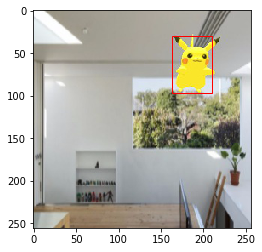

In [15]:
import numpy as np

img = batch.data[0][0].asnumpy()  # grab the first image, convert to numpy array
img = img.transpose((1, 2, 0))  # we want channel to be the last dimension
img += np.array([123, 117, 104])
img = img.astype(np.uint8)  # use uint8 (0-255)
# draw bounding boxes on image
for label in batch.label[0][0].asnumpy():
    if label[0] < 0:
        break
    print(label)
    xmin, ymin, xmax, ymax = [int(x * data_shape) for x in label[1:5]]
    rect = plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, fill=False, edgecolor=(1, 0, 0), linewidth=1)
    plt.gca().add_patch(rect)
plt.imshow(img)
plt.show()

In [14]:
from mxnet.contrib.ndarray import MultiBoxTarget
def training_targets(default_anchors, class_predicts, labels):
    class_predicts = nd.transpose(class_predicts, axes=(0, 2, 1))
    z = MultiBoxTarget(*[default_anchors, labels, class_predicts])
    box_target = z[0]  # box offset target for (x, y, width, height)
    box_mask = z[1]  # mask is used to ignore box offsets we don't want to penalize, e.g. negative samples
    cls_target = z[2]  # cls_target is an array of labels for all anchors boxes
    return box_target, box_mask, cls_target

In [15]:
class FocalLoss(gluon.loss.Loss):
    def __init__(self, axis=-1, alpha=0.25, gamma=2, batch_axis=0, **kwargs):
        super(FocalLoss, self).__init__(None, batch_axis, **kwargs)
        self._axis = axis
        self._alpha = alpha
        self._gamma = gamma

    def hybrid_forward(self, F, output, label):
        output = F.softmax(output)
        pt = F.pick(output, label, axis=self._axis, keepdims=True)
        loss = -self._alpha * ((1 - pt) ** self._gamma) * F.log(pt)
        return F.mean(loss, axis=self._batch_axis, exclude=True)

class SmoothL1Loss(gluon.loss.Loss):
    def __init__(self, batch_axis=0, **kwargs):
        super(SmoothL1Loss, self).__init__(None, batch_axis, **kwargs)

    def hybrid_forward(self, F, output, label, mask):
        loss = F.smooth_l1((output - label) * mask, scalar=1.0)
        return F.mean(loss, self._batch_axis, exclude=True)

In [16]:
cls_loss = FocalLoss()
box_loss = SmoothL1Loss()

cls_metric = mx.metric.Accuracy()
box_metric = mx.metric.MAE()

In [17]:
ctx = mx.gpu()  # it may takes too long to train using CPU
try:
    _ = nd.zeros(1, ctx=ctx)
    # pad label for cuda implementation
    train_data.reshape(label_shape=(3, 5))
    train_data = test_data.sync_label_shape(train_data)
except mx.base.MXNetError as err:
    print('No GPU enabled, fall back to CPU, sit back and be patient...')
    ctx = mx.cpu()

No GPU enabled, fall back to CPU, sit back and be patient...


In [18]:
net = ToySSD(num_class)
net.initialize(mx.init.Xavier(magnitude=2), ctx=ctx)

In [19]:
net.collect_params().reset_ctx(ctx)
trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': 0.1, 'wd': 5e-4})

In [20]:
epochs = 150  # set larger to get better performance
log_interval = 20
from_scratch = False  # set to True to train from scratch
if from_scratch:
    start_epoch = 0
else:
    import os
    start_epoch = 148
    pretrained = 'ssd_pretrained.params'
    sha1 = 'fbb7d872d76355fff1790d864c2238decdb452bc'
    url = 'https://apache-mxnet.s3-accelerate.amazonaws.com/gluon/models/ssd_pikachu-fbb7d872.params'
    if not os.path.exists(pretrained):
        print('Downloading', pretrained, url)
        download(url, fname=pretrained, overwrite=True)
    net.load_params(pretrained, ctx)

In [39]:
import time
from mxnet import autograd as ag
for epoch in range(start_epoch, epochs):
    # reset iterator and tick
    train_data.reset()
    cls_metric.reset()
    box_metric.reset()
    tic = time.time()
    # iterate through all batch
    for i, batch in enumerate(train_data):
        btic = time.time()
        # record gradients
        with ag.record():
            x = batch.data[0].as_in_context(ctx)
            y = batch.label[0].as_in_context(ctx)
            default_anchors, class_predictions, box_predictions = net(x)
            box_target, box_mask, cls_target = training_targets(default_anchors, class_predictions, y)
            # losses
            loss1 = cls_loss(class_predictions, cls_target)
            loss2 = box_loss(box_predictions, box_target, box_mask)
            # sum all losses
            loss = loss1 + loss2
            # backpropagate
            loss.backward()
        # apply
        trainer.step(batch_size)
        # update metrics
        cls_metric.update([cls_target], [nd.transpose(class_predictions, (0, 2, 1))])
        box_metric.update([box_target], [box_predictions * box_mask])
        if (i + 1) % log_interval == 0:
            name1, val1 = cls_metric.get()
            name2, val2 = box_metric.get()
            print('[Epoch %d Batch %d] speed: %f samples/s, training: %s=%f, %s=%f'
                  %(epoch ,i, batch_size/(time.time()-btic), name1, val1, name2, val2))

    # end of epoch logging
    name1, val1 = cls_metric.get()
    name2, val2 = box_metric.get()
    print('[Epoch %d] training: %s=%f, %s=%f'%(epoch, name1, val1, name2, val2))
    print('[Epoch %d] time cost: %f'%(epoch, time.time()-tic))

# we can save the trained parameters to disk
net.save_params('ssd_%d.params' % epochs)

[Epoch 148 Batch 19] speed: 9.102888 samples/s, training: accuracy=0.997593, mae=0.001807
[Epoch 148] training: accuracy=0.967471, mae=0.001775
[Epoch 148] time cost: 327.173620
[Epoch 149 Batch 19] speed: 4.678890 samples/s, training: accuracy=0.997639, mae=0.001787
[Epoch 149] training: accuracy=0.967499, mae=0.001773
[Epoch 149] time cost: 375.186549


In [21]:
import numpy as np
import cv2
def preprocess(image):
    """Takes an image and apply preprocess"""
    # resize to data_shape
    image = cv2.resize(image, (data_shape, data_shape))
    # swap BGR to RGB
    image = image[:, :, (2, 1, 0)]
    # convert to float before subtracting mean
    image = image.astype(np.float32)
    # subtract mean
    image -= np.array([123, 117, 104])
    # organize as [batch-channel-height-width]
    image = np.transpose(image, (2, 0, 1))
    image = image[np.newaxis, :]
    # convert to ndarray
    image = nd.array(image)
    return image

image = cv2.imread('/Users/jintian/Downloads/images.jpeg')
x = preprocess(image)
print('x', x.shape)

x (1, 3, 256, 256)


In [22]:
anchors, cls_preds, box_preds = net(x.as_in_context(ctx))
print('anchors', anchors)
print('class predictions', cls_preds)
print('box delta predictions', box_preds)

anchors 
[[[-0.084375   -0.084375    0.115625    0.115625  ]
  [-0.12037501 -0.12037501  0.15162501  0.15162501]
  [-0.12579636 -0.05508568  0.15704636  0.08633568]
  ..., 
  [ 0.01949999  0.01949999  0.98049998  0.98049998]
  [-0.12225395  0.18887302  1.12225389  0.81112695]
  [ 0.18887302 -0.12225395  0.81112695  1.12225389]]]
<NDArray 1x5444x4 @cpu(0)>
class predictions 
[[[ 0.32303929 -1.20483756]
  [ 0.55747592 -1.20865107]
  [ 1.1201421  -0.99669844]
  ..., 
  [-0.15391032 -1.23373842]
  [ 0.60861337 -0.97289634]
  [ 0.36026725 -0.86496061]]]
<NDArray 1x5444x2 @cpu(0)>
box delta predictions 
[[ 0.08175568 -0.30560651 -0.43925959 ..., -0.20252465 -0.08635856
  -0.21571182]]
<NDArray 1x21776 @cpu(0)>


In [23]:
from mxnet.contrib.ndarray import MultiBoxDetection
# convert predictions to probabilities using softmax
cls_probs = nd.SoftmaxActivation(nd.transpose(cls_preds, (0, 2, 1)), mode='channel')
# apply shifts to anchors boxes, non-maximum-suppression, etc...
output = MultiBoxDetection(*[cls_probs, box_preds, anchors], force_suppress=True, clip=False)
print(output)


[[[ 0.          0.55847991  0.34132034  0.32976666  0.62483597  0.76039493]
  [-1.          0.54251319  0.31254828  0.31836647  0.64717078  0.74577004]
  [ 0.          0.50799263  0.37149715  0.2616871   0.60698146  0.56812239]
  ..., 
  [-1.         -1.         -1.         -1.         -1.         -1.        ]
  [-1.         -1.         -1.         -1.         -1.         -1.        ]
  [-1.         -1.         -1.         -1.         -1.         -1.        ]]]
<NDArray 1x5444x6 @cpu(0)>


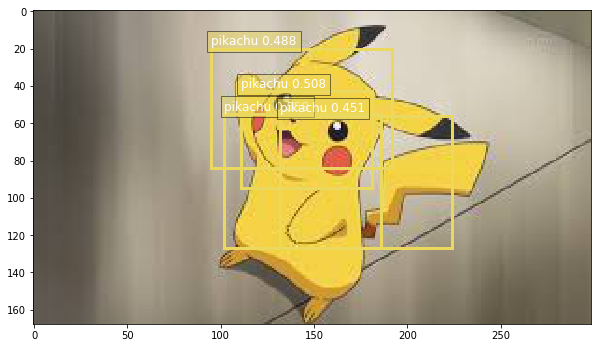

In [24]:
def display(img, out, thresh=0.5):
    import random
    import matplotlib as mpl
    mpl.rcParams['figure.figsize'] = (10,10)
    pens = dict()
    plt.clf()
    plt.imshow(img)
    for det in out:
        cid = int(det[0])
        if cid < 0:
            continue
        score = det[1]
        if score < thresh:
            continue
        if cid not in pens:
            pens[cid] = (random.random(), random.random(), random.random())
        scales = [img.shape[1], img.shape[0]] * 2
        xmin, ymin, xmax, ymax = [int(p * s) for p, s in zip(det[2:6].tolist(), scales)]
        rect = plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, fill=False,
                             edgecolor=pens[cid], linewidth=3)
        plt.gca().add_patch(rect)
        text = class_names[cid]
        plt.gca().text(xmin, ymin-2, '{:s} {:.3f}'.format(text, score),
                       bbox=dict(facecolor=pens[cid], alpha=0.5),
                       fontsize=12, color='white')
    plt.show()

display(image[:, :, (2, 1, 0)], output[0].asnumpy(), thresh=0.45)